In [64]:
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib.patches import Wedge
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 10,
    "figure.titlesize": 14
})


# Extract SEF headers to Excel

In [107]:
root = Path("/scratch3/PALAEO-RA/daily_data/final/")
rows = []

files = list(root.rglob("*.tsv")) # gets all tsv files recursively

def clean_line(line):
    line = line.rstrip("\n")           # remove newline
    # Split on tabs but keep empty fields
    parts = line.split("\t")
    # Remove empty fields at the end only
    while parts and parts[-1] == "":
        parts.pop()
    # Rejoin back with single tabs
    return "\t".join(parts)


for path in files:
    
    # ------------ read metadata until "Year" ------------
    meta = {}
    
    # read whole file
    with path.open("r", encoding="utf-8") as f:
        for raw in f:
            line = clean_line(raw)
            # stop at start of the actual SEF table
            if line.startswith("Year"):
                break
            if "\t" in line:
                key, val = line.split("\t", 1)
                meta[key.strip()] = val.strip()
    
    # ------------ detect table header row ------------
    with path.open("r", encoding="utf-8") as f:
        table_start = None
        for i, raw in enumerate(f):
            line = clean_line(raw)
            if line.startswith("Year"):
                table_start = i
                break

    # ------------ read the table safely ------------
    df_file = pd.read_csv(
        path,
        sep="\t",
        header=table_start,
        dtype=str,
        on_bad_lines="skip"
    )

    # ------------ compute start/end date ------------
    meta["filename"]   = path.name
    meta["start_date"] = df_file["Year"].iloc[0] + "-" + df_file["Month"].iloc[0] + "-" + df_file["Day"].iloc[0]
    meta["end_date"]   = df_file["Year"].iloc[-1] + "-" + df_file["Month"].iloc[-1] + "-" + df_file["Day"].iloc[-1]

    rows.append(meta)


In [108]:
df = pd.DataFrame(rows)

# drop last column of df 
df = df.iloc[:, :-1]
df.to_csv("/scratch3/PALAEO-RA/daily_data/final/metadata_summary.csv", index=False)

# print column names
print(df.columns.tolist())
df.head()

['SEF', 'ID', 'Name', 'Lat', 'Lon', 'Alt', 'Source', 'Link', 'Vbl', 'Stat', 'Units', 'Meta', 'filename', 'start_date', 'end_date']


,SEF,ID,Name,Lat,Lon,Alt,Source,Link,Vbl,Stat,Units,Meta,filename,start_date,end_date
0,1.0.0,Hochobir,TG_SOUID_230276,46.5,14.483056,2041,ECA&D,knmi-ecad-assets-prd.s3.amazonaws.com/download...,ta,mean,C,Mean temperature calculated as average of TN a...,ECA&D_Hochobir_18810320-19440630_ta.tsv,1881-3-20,1944-6-30
1,1.0.0,Sonnblick,TG_SOUID_236607,47.053889,12.9575,3109,ECA&D,knmi-ecad-assets-prd.s3.amazonaws.com/download...,ta,mean,C,Mean temperature calculated as average of TN a...,ECA&D_Sonnblick_18861001-20240331_ta.tsv,1886-10-1,2024-3-31
2,1.0.0,Palatine-Society_Budapest,Budapest,47.4925,19.0513888888889,168,PALAEO-RA,NaN,ta,point,C,"Observer=Weis, Bruna | Instrument=Palatine Soc...",Budapest_17811108-17921231_ta_subdaily_qc.tsv,1781-11-8,1792-12-31
3,1.0.0,Palatine-Society_Budapest,Budapest,47.4925,19.0513888888889,168,PALAEO-RA,NaN,rr,sum,mm,Observer=Bruna | QC software=dataresqc v1.1.1,Budapest_17811101-17861231_rr_daily_qc.tsv,1781-11-8,1786-12-31
4,1.0.0,Palatine-Society_Budapest,Budapest,47.4925,19.0513888888889,168,PALAEO-RA,NaN,ta,mean,C,Observer=Bruna | QC software=dataresqc v1.1.1,Budapest_17880101-17881231_ta_daily_qc.tsv,1788-1-1,1788-12-31


In [109]:
df[(df["Source"]=="Paris") & (df['Vbl']=="p")].sort_values("start_date")

,SEF,ID,Name,Lat,Lon,Alt,Source,Link,Vbl,Stat,Units,Meta,filename,start_date,end_date
222,1.0.0,1,Cluny,48.85,2.34,57,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,"Paris Inches, 1PinHg=36.1hPa | PTC=Y | PGC=Y |...",Paris_1_17471220-17591231_p_subdaily_qc.tsv,1747-12-20,1759-12-31
229,1.0.0,2,Roux,48.85,2.34,57,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,"Paris Inches, 1PinHg=36.1hPa | PTC=Y | PGC=Y |...",Paris_2_17600105-17760731_p_subdaily_qc.tsv,1760-1-5,1776-7-31
226,1.0.0,3,Cotte,48.98,2.32,106.5,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,"Paris Inches, 1PinHg=36.1hPa | PTC=Y | PGC=Y |...",Paris_3_17760801-17841231_p_subdaily_qc.tsv,1776-8-1,1784-12-31
227,1.0.0,4,Observatoire,48.836,2.337,67,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,PTC=Y | PGC=Y | QC software=dataresqc v1.1.1,Paris_4_17850101-18720615_p_subdaily_qc.tsv,1785-1-1,1872-6-15
224,1.0.0,5,Montsouris Observatory,48.8167,2.333,78,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,PTC=Y | PGC=Y | QC software=dataresqc v1.1.1,Paris_5_18720617-18961231_p_subdaily_qc.tsv,1872-6-17,1896-12-31
228,1.0.0,7,Montsouris Observatory,48.8167,2.333,77,Paris,https://doi.org/10.1002/gdj3.226,p,point,hPa,PTC=Y | PGC=Y | QC software=dataresqc v1.1.1,Paris_7_18961231-20111106_p_subdaily_qc.tsv,1896-12-31,2011-11-6


**find adjacent files that should be counted as 1**

In [113]:
end_i

'1852-4-30'

In [116]:
df2 = df.copy()

# round coords to 3 decimals
df2["Lat3"] = df2["Lat"].round(3)
df2["Lon3"] = df2["Lon"].round(3)

# sort so adjacency makes sense
df2 = df2.sort_values(["Vbl", "Stat", "Units", "Lat3", "Lon3", "start_date"])
df2["start_int"] = df2["start_date"].str.replace("-", "").astype(int)
df2["end_int"]   = df2["end_date"].str.replace("-", "").astype(int)

# group key
grp_cols = ["Vbl", "Stat", "Units", "Lat3", "Lon3"]

# check adjacency
for key, sub in df2.groupby(grp_cols):
    sub = sub.sort_values("start_date")

    for i in range(len(sub)-1):
        end_i = sub.iloc[i]["end_date"]
        start_j = sub.iloc[i+1]["start_date"]

        # approximate check: same year or next year AND day-of-year difference < 366
        sy = int(str(start_j)[:4])
        ey = int(str(end_i)[:4])

        if (sy == ey or sy == ey+1):
            f1 = sub.iloc[i]["filename"]
            f2 = sub.iloc[i+1]["filename"]
            print(f"WARNING: {f1} and {f2} can be grouped (end={end_i}, start={start_j})")

# Table where is the oldest Record

In [21]:
df = pd.read_csv("/scratch3/PALAEO-RA/daily_data/final/metadata_summary.csv")


In [48]:
date_parts = df['start_date'].str.split('-', expand=True).astype(int)
df['start_year'] = date_parts[0]
df['start_month'] = date_parts[1]
df['start_day'] = date_parts[2]

# numeric key to compare without needing datetime
df['start_ymd'] = df['start_year'] * 10000 + df['start_month'] * 100 + df['start_day']

# find index of row with oldest day per var
idx = df.groupby('Vbl')['start_ymd'].idxmin()

oldest_records = df.loc[idx, ['Vbl', 'Name', 'start_date', 'Source']].copy()
oldest_records = oldest_records.sort_values(by='Vbl').reset_index(drop=True)

# only show some of the variables of choice and in this order
vars_of_interest = ['ta', 'p', 'dd', 'Tx', 'Tn', 'rr']

# write the full names of the variables
mapping = {
    'ta': 'Temperature',
    'p':  'Pressure',
    'dd': 'Wind Direction',
    'Tx': 'Maximum Temperature',
    'Tn': 'Minimum Temperature',
    'rr': 'Precipitation'
}

sel = oldest_records[oldest_records['Vbl'].isin(vars_of_interest)]
sel = sel.set_index('Vbl').loc[vars_of_interest].reset_index()
sel['Vbl'] =  sel['Vbl'].map(mapping)

sel

latex_table = sel.to_latex(
    index=False,
    column_format="llll"  # adjust if you have more columns
)

print(latex_table)


\begin{tabular}{llll}
\toprule
Vbl & Name & start_date & Source \\
\midrule
Temperature & Oxford & 1666-7-4 & Boyle, General history of the air, London, 1692, pag. 104 \\
Pressure & Oxford & 1666-7-4 & PALAEO-RA \\
Wind Direction & Oxford & 1666-7-4 & PALAEO-RA \\
Maximum Temperature & Milan & 1763-1-1 & Maugeri, Maurizio et al. “Daily Milan temperature and pressure series (1763-1998): Completing and homogenising the data.” Climatic Change 53 (2002): 119-149. \\
Minimum Temperature & Milan & 1763-1-1 & Maugeri, Maurizio et al. “Daily Milan temperature and pressure series (1763-1998): Completing and homogenising the data.” Climatic Change 53 (2002): 119-149. \\
Precipitation & Paris & 1665-2-1 & Pliemon, T., Foelsche, U., Rohr, C., & Pfister, C. (2023). Precipitation reconstructions for Paris based on the observations by Louis Morin, 1665–1713 CE [Data set]. Zenodo. \\
\bottomrule
\end{tabular}



# Make Station Maps

In [43]:
df = pd.read_csv("/scratch3/PALAEO-RA/daily_data/final/metadata_summary.csv")

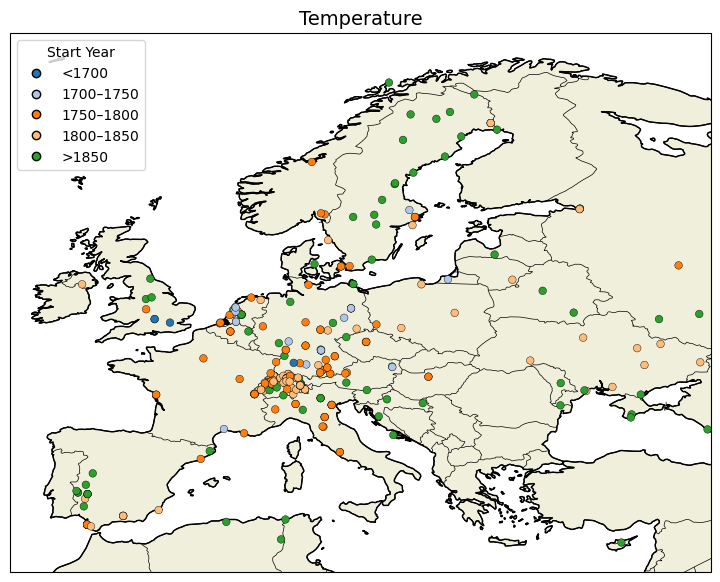

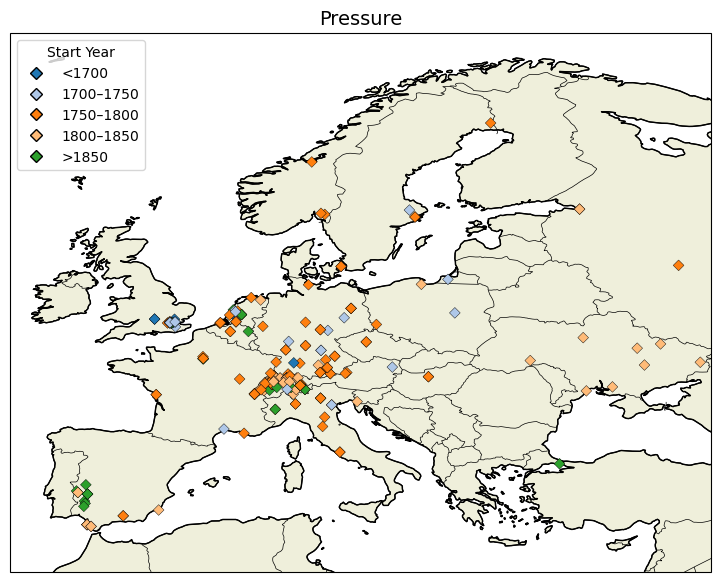

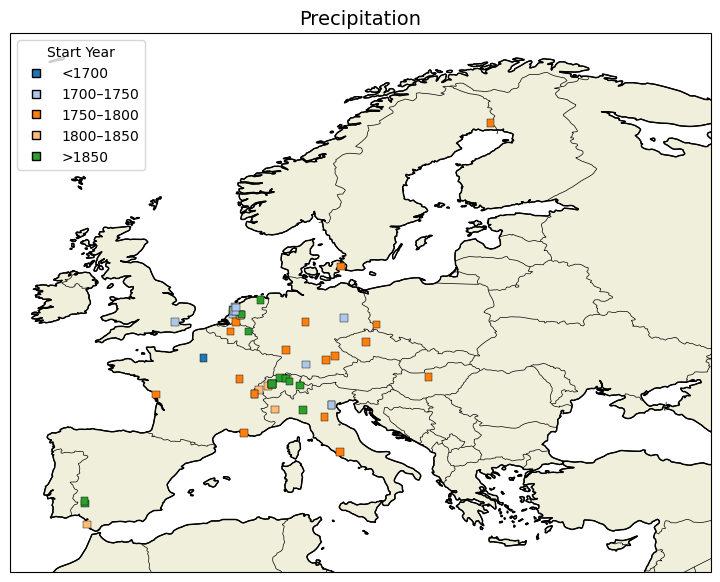

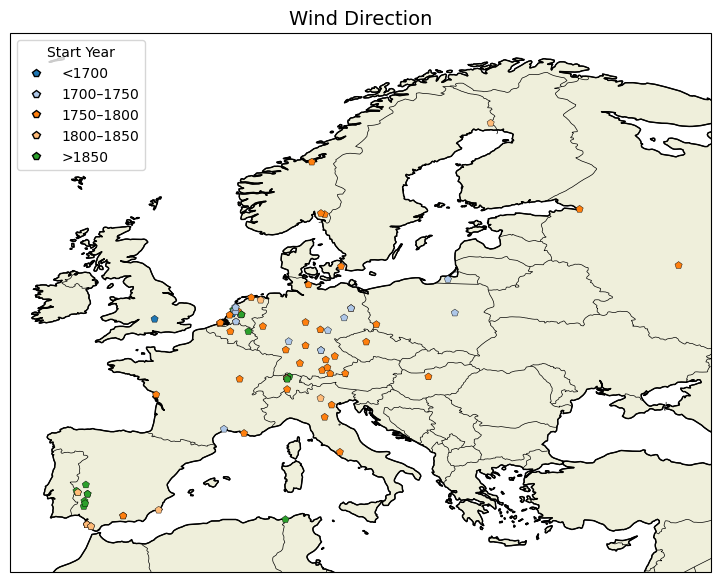

In [ ]:
start_year = df['start_date'].str.split("-").str[0].astype(int)
end_year   = df['end_date'].str.split("-").str[0].astype(int)

# define bins for colors
bins   = [-9999, 1700, 1750, 1800, 1850, 1900]
labels = ["<1700", "1700–1750", "1750–1800", "1800–1850", ">1850"]

df["start_period"] = pd.cut(start_year, bins=bins, labels=labels)
df['start_code']   = df['start_period'].cat.codes


################################################################

# numeric codes for color values
codes = df["start_period"].cat.codes
cats  = df["start_period"].cat.categories
cmap  = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(len(cats))] # pick 5 colors within tab20

# marker mapping
var_markers = {
    "ta": "o",
    "p":  "D", # diamond
    "rr": "s", # square
    "dd": "p", # pentagon
    "w":  "*",
}

valid_vars = ["ta", "p", "rr", "rh", "dd", "w", "Tn", "Tx"]
valid_vars= ["ta", "p", "rr", "dd"]

# one map per variable
for var in valid_vars:
    df_var = df[df["Vbl"] == var].copy()

    marker = var_markers.get(var, "X")
    df_var_codes = df_var["start_period"].cat.codes
    point_colors = [colors[code] for code in df_var_codes]

    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-12, 40, 33, 73], crs=ccrs.PlateCarree())

    # Add contours
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black')

    # plot all points at once and color by period
    plt.scatter(
        df_var["Lon"].astype(float),
        df_var["Lat"].astype(float),
        
        facecolor=point_colors,
        s=30,
        edgecolor="black",
        linewidth=0.3,
        marker=var_markers.get(var, "o"),
        transform=ccrs.PlateCarree(),
        label=var,
        alpha=1,
        zorder=3
    )

    # ----- custom legend -----
    legend_elements = [
        Line2D(
            [0], [0],
            marker=var_markers.get(var, "o"),
            color="white",
            label=str(cat),
            markerfacecolor=colors[i],
            markeredgecolor="black",
            markersize=6,
            linewidth=0.2
        )
        for i, cat in enumerate(cats)
    ]

    # legend
    plt.legend(handles=legend_elements, title="Start Year", loc="upper left")
    plt.title(f"{mapping[var]}", fontsize=14)
    plt.savefig(f"/scratch2/ccorbella/code/dataprep/image/station_map_start_year_{var}.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

# Make a Pie Chart

In [7]:
var_counts = df["Vbl"].value_counts()
total_counts = var_counts.sum()
var_counts

Vbl
ta     360
p      283
dd     101
rr      52
Tn      37
Tx      33
w       29
rh      18
eee      8
rrt      6
tb       4
fs       1
Name: count, dtype: int64

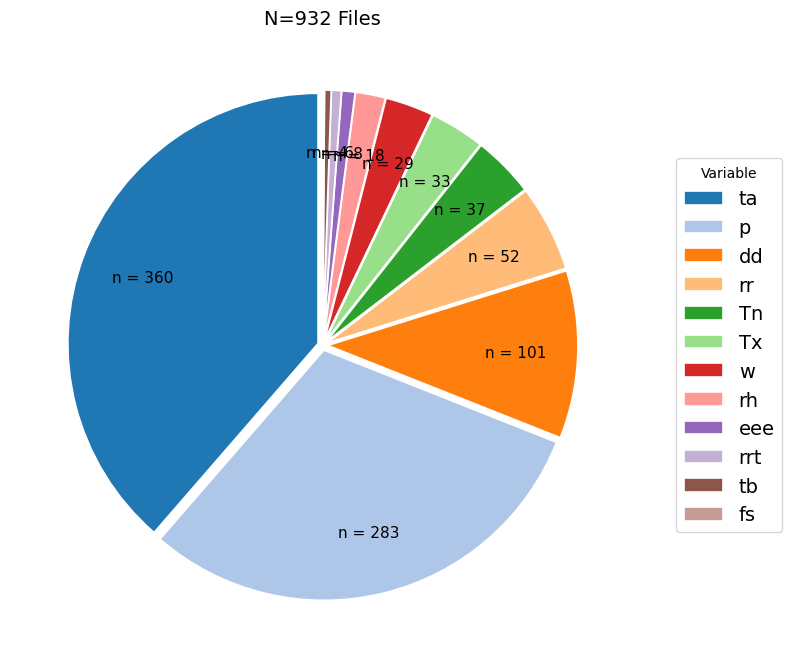

In [8]:
def count_label(pct):
    '''write number of counts instead of percentage and hide for tiny slices'''
    count = int(round(pct/100 * total_counts))
    if count <= 2:
        return ""         # hide labels for tiny slices
    return f"n = {count}"

labels = var_counts.index

# explode a tiny amount for all slices for aesthetics
plt.figure(figsize=(8, 8))

patches, texts, autotexts = plt.pie(
    var_counts.values,
    labels=None,               # we'll add custom legend
    explode=[0.02] * len(var_counts),
    autopct=count_label,
    startangle=90,
    pctdistance=0.75,
    colors=plt.get_cmap("tab20").colors,
    wedgeprops=dict(edgecolor="white", linewidth=1.2)
)

# format inside-text
for at in autotexts:
    at.set_color("black")
    at.set_fontsize(11)

plt.title(f"N={total_counts} Files", fontsize=14)

# custom legend (so labels don't clutter the pie)
plt.legend(
    patches,
    labels,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    title="Variable"
)

plt.tight_layout()
plt.savefig("/scratch2/ccorbella/code/dataprep/image/pie_chart.png", dpi=300, bbox_inches="tight")
plt.show()

# Make Timeseries of Num Vars

In [136]:
# we can't use datetime directly because of invalid dates before 1677
df["start_year"] = df["start_date"].astype(str).str.split("-").str[0].astype(int)
df["end_year"]   = df["end_date"].astype(str).str.split("-").str[0].astype(int)

min_year = df["start_year"].min()
max_year = df["end_year"].max()

years = pd.Index(range(int(min_year), max_year + 1))

coverage = pd.DataFrame(index=years, columns=valid_vars).fillna(0)

for var in valid_vars:
    dfv = df[df["Vbl"] == var]

    for _, row in dfv.iterrows():
        coverage.loc[row["start_year"]:row["end_year"], var] += 1

/tmp/ipykernel_3019769/3210244124.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  coverage = pd.DataFrame(index=years, columns=valid_vars).fillna(0)


In [154]:
ax.get_ylim()[1] * 0.95

66.8325

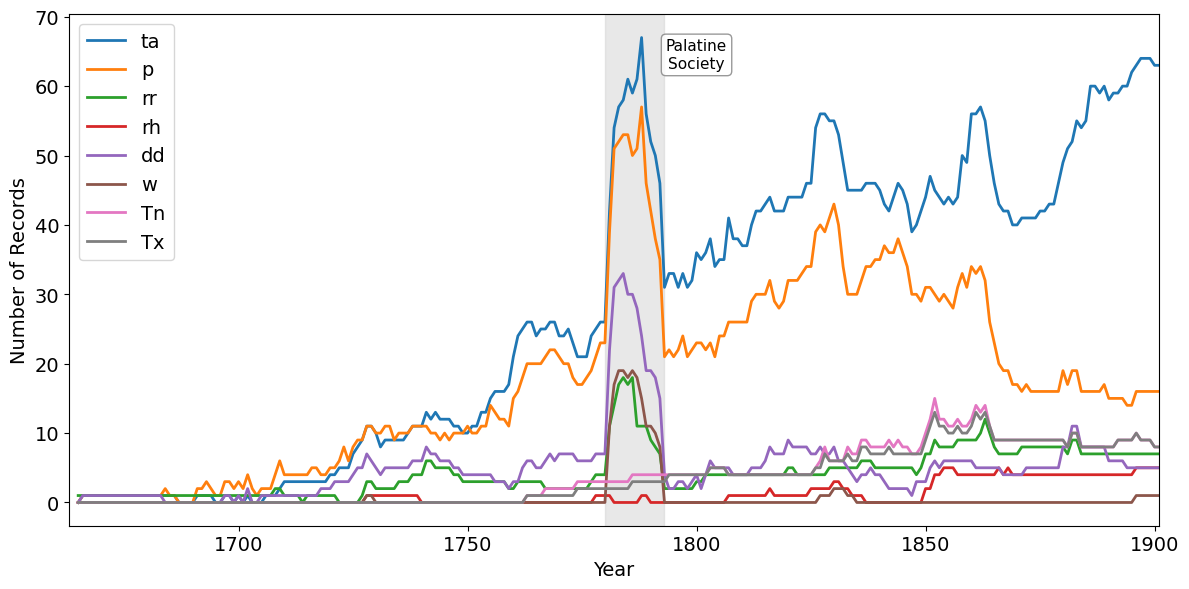

In [167]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

# highlight Palatine Society period
ax.axvspan(1780, 1793, color="lightgray", alpha=0.5, zorder=0)


for var in valid_vars:
    plt.plot(
        coverage.index,
        coverage[var],
        label=var,
        linewidth=2
    )

ax.text(
    x=1800,
    y=ax.get_ylim()[1] * 0.95,  # near the top of the plot
    s="Palatine\nSociety",      # newline
    ha="center",
    va="top",
    fontsize=11,
    bbox=dict(
        facecolor="white",
        edgecolor="gray",
        alpha=0.8,
        boxstyle="round,pad=0.3"
    )
)

plt.xlabel("Year")
plt.xlim(min_year-2,1901)
ax.set_xticks([1700, 1750, 1800, 1850, 1900])

plt.ylabel("Number of Records")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("/scratch2/ccorbella/code/dataprep/image/temporal_coverage_timeseries.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()